**# Specific Test II. Lens Finding**

---

---


For this prolem set, I have used with ResNet18 pretrained model in PyTorch image classification into lensed and non-lensed categories. As the dataset is higly imbalanced with lensed to non-lensed data ratio being  1730 : 28675 , we can opt for WeighedRandomSampler or FocalLoss criterion method. Considering the RUC scores achieved, the FocalLoss method is implemented for this scenario.




In [1]:
!gdown 1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5

Downloading...
From (original): https://drive.google.com/uc?id=1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5
From (redirected): https://drive.google.com/uc?id=1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5&confirm=t&uuid=04243d79-e798-46e9-8edf-002036158e72
To: /content/lens-finding-test.zip
100% 2.11G/2.11G [00:22<00:00, 94.6MB/s]


In [2]:
!unzip -q "/content/lens-finding-test.zip"

In [ ]:
import os
#!ls "/content/test_lenses"
file_count1 = len(os.listdir("/content/train_nonlenses"))
file2=len(os.listdir("/content/train_lenses"))
print( file_count1,file2)

28675 1730


In [3]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [1]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os
notebook_path = os.getcwd()
print(notebook_path)

/content


In [4]:
#Forming custom dataset with lensed and non_lensed data

class Dataset1(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content"
        positive_train="train_lenses"
        negative_train='train_nonlenses'
        positive_test="test_lenses"
        negative_test='test_nonlenses'

        positive_train_file_path=os.path.join(directory,positive_train)
        negative_train_file_path=os.path.join(directory,negative_train)
        positive_test_file_path=os.path.join(directory,positive_test)
        negative_test_file_path=os.path.join(directory,negative_test)
        positive_train_files=[os.path.join(positive_train_file_path,file) for file in os.listdir(positive_train_file_path) if file.endswith(".npy")]
        negative_train_files=[os.path.join(negative_train_file_path,file) for file in os.listdir(negative_train_file_path) if file.endswith(".npy")]
        positive_test_files=[os.path.join(positive_test_file_path,file) for file in os.listdir(positive_test_file_path) if file.endswith(".npy")]
        negative_test_files=[os.path.join(negative_test_file_path,file) for file in os.listdir(negative_test_file_path) if file.endswith(".npy")]

        number_of_train_samples=len(positive_train_files)+len(negative_train_files)
        number_of_test_samples=len(positive_test_files)+len(negative_test_files)
        number_of_samples=number_of_train_samples+number_of_test_samples
        self.all_files=[None]*number_of_samples
        self.all_files[:len(positive_train_files)]=positive_train_files
        self.all_files[len(positive_train_files):number_of_train_samples]=negative_train_files
        self.all_files[number_of_train_samples:(number_of_train_samples+len(positive_test_files))]=positive_test_files
        self.all_files[(number_of_train_samples+len(positive_test_files)):]=negative_test_files



        self.transform = transform

        #torch.LongTensor is used to classify two set of images with label 0 and 1
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[:len(positive_train_files)]=1
        self.Y[len(positive_train_files):number_of_train_samples]=0
        self.Y[number_of_train_samples:(number_of_train_samples+len(positive_test_files))]=1
        self.Y[(number_of_train_samples+len(positive_test_files)):]=0


        if train:
            self.all_files=self.all_files[0:number_of_train_samples]
            self.Y=self.Y[0:number_of_train_samples]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[number_of_train_samples:]
            self.Y=self.Y[number_of_train_samples:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len
    # Getter
    def __getitem__(self, idx):

        image=np.load(self.all_files[idx])

        y=self.Y[idx]


        if self.transform:
            image = self.transform(image)

        return image, y





In [5]:
#Training the dataset
train_dataset = Dataset1(train=True)
validation_dataset = Dataset1(train=False)
print("done")

done


In [6]:
# using pretrained ResNet18 model
model=models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
for param in model.parameters():
    param.requires_grad=False

In [8]:
# Last layer added to ResNet18 , which gives the output
model.fc=nn.Linear(512,2)

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F



#FocalLoss class uses hyperparameters alpha and gamma, which modifies the relative weights of the classes

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            alpha = self.alpha.to(targets.device)
            alpha_t = alpha[targets]
            focal_loss = alpha_t * focal_loss

        return focal_loss.mean()






Epoch 1, ROC AUC: 0.8283
Epoch 2, ROC AUC: 0.8515
Epoch 3, ROC AUC: 0.8710
Epoch 4, ROC AUC: 0.8752
Epoch 5, ROC AUC: 0.8753
Epoch 6, ROC AUC: 0.8727
Epoch 7, ROC AUC: 0.8635
Epoch 8, ROC AUC: 0.8591
Epoch 9, ROC AUC: 0.8718
Epoch 10, ROC AUC: 0.8680


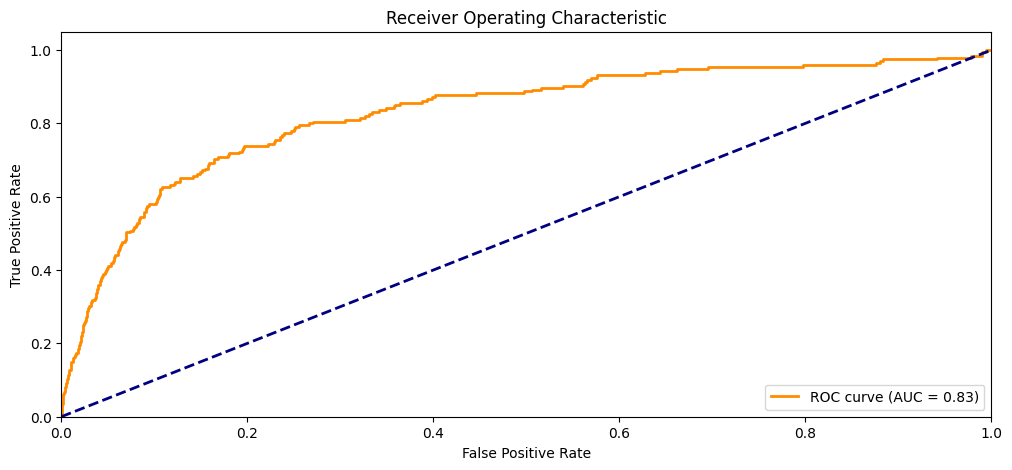

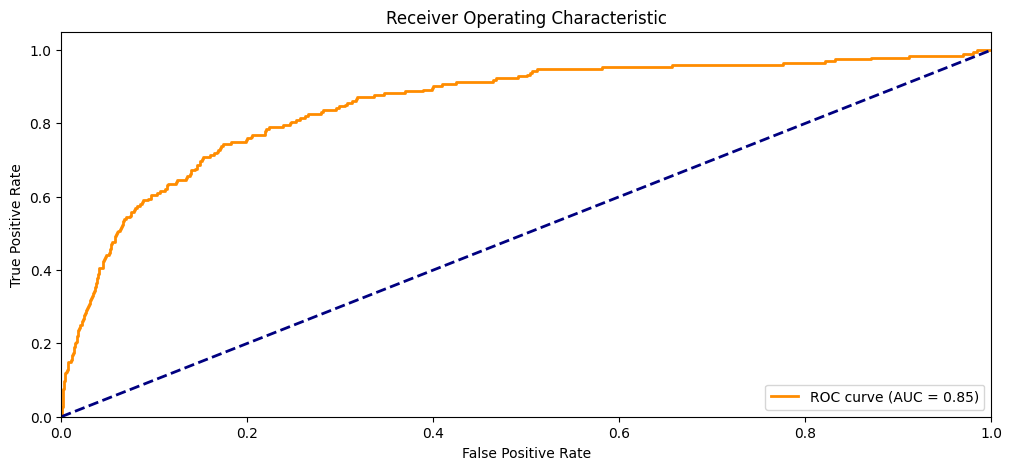

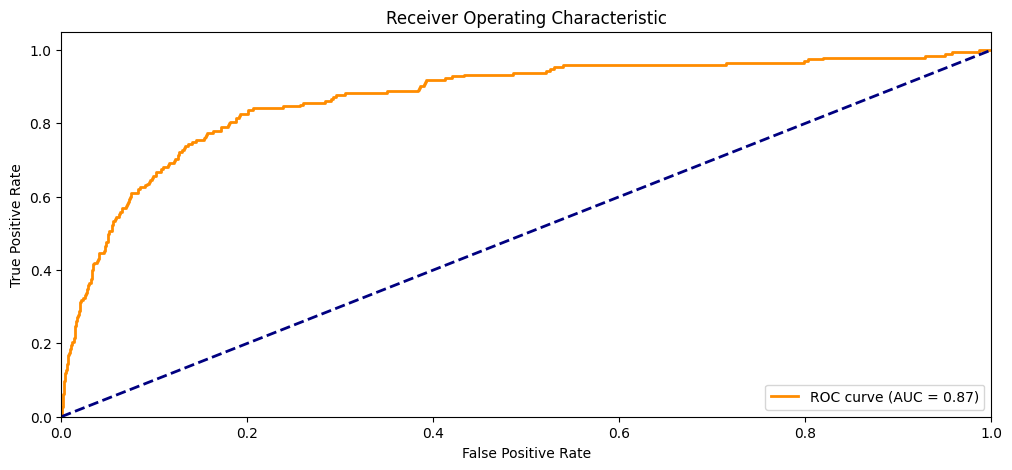

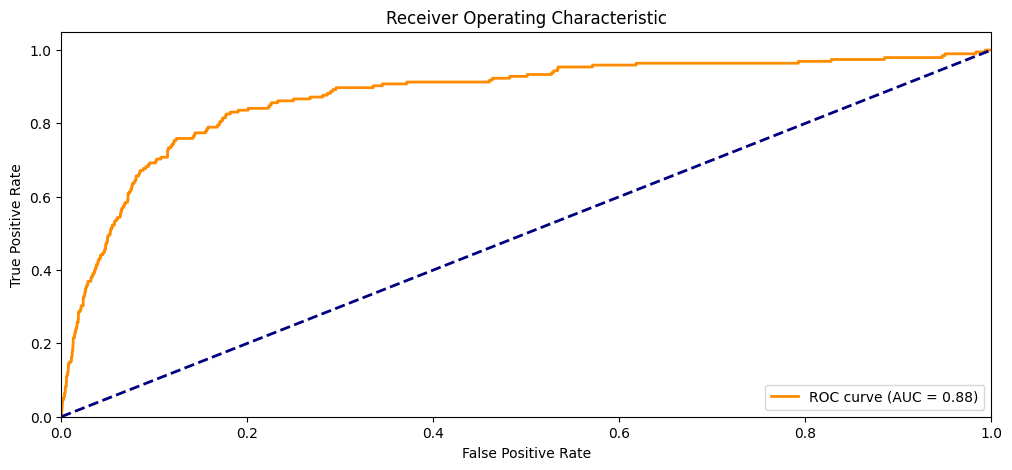

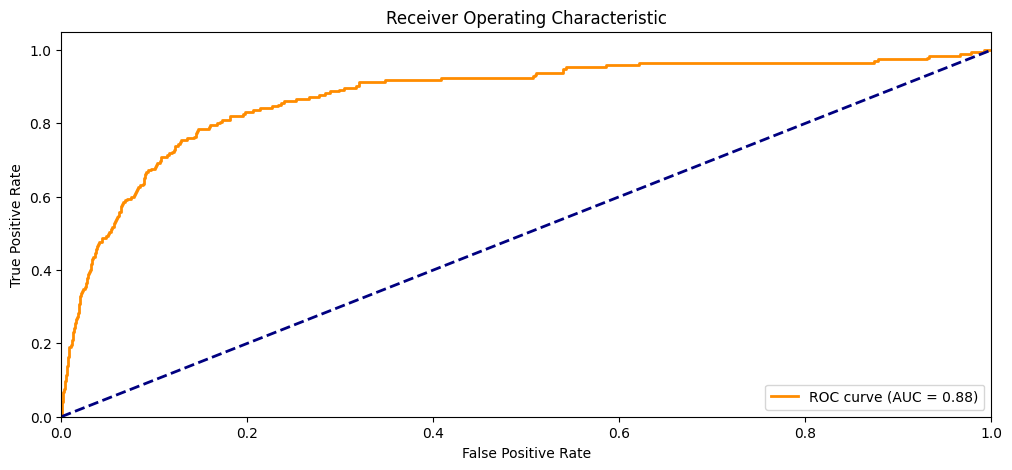

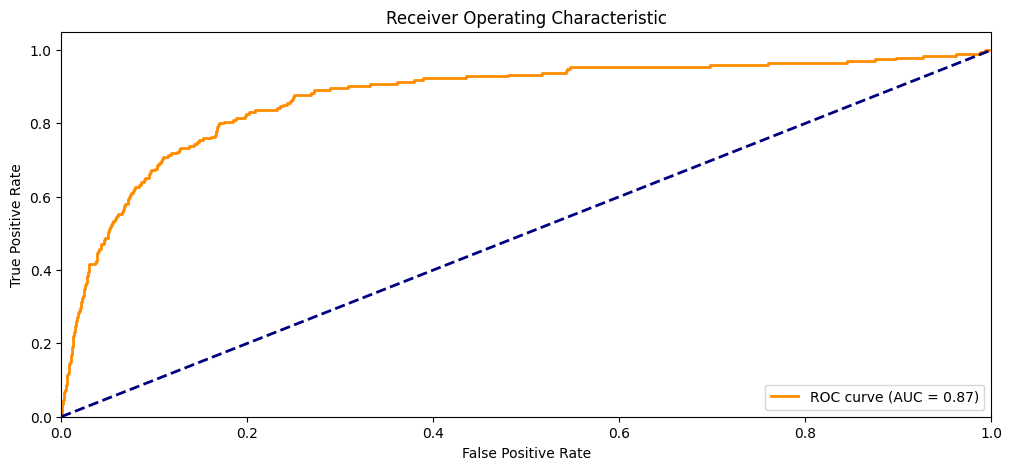

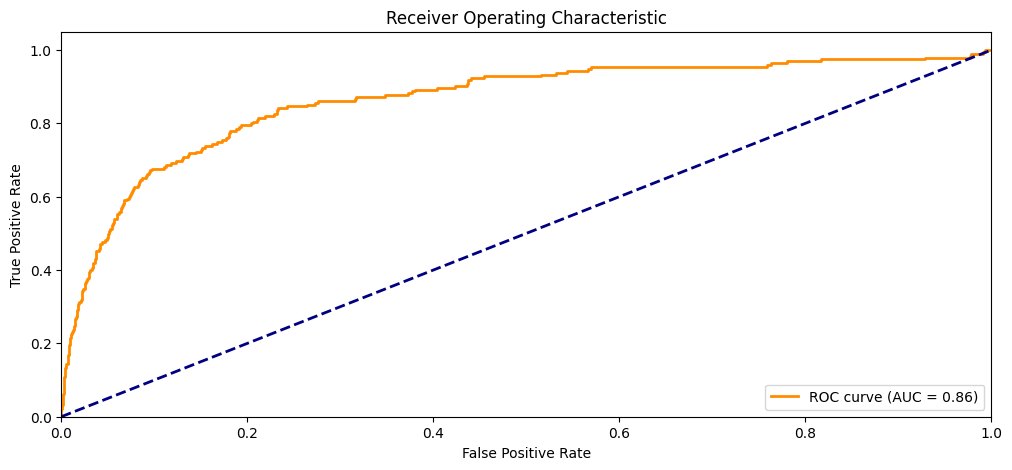

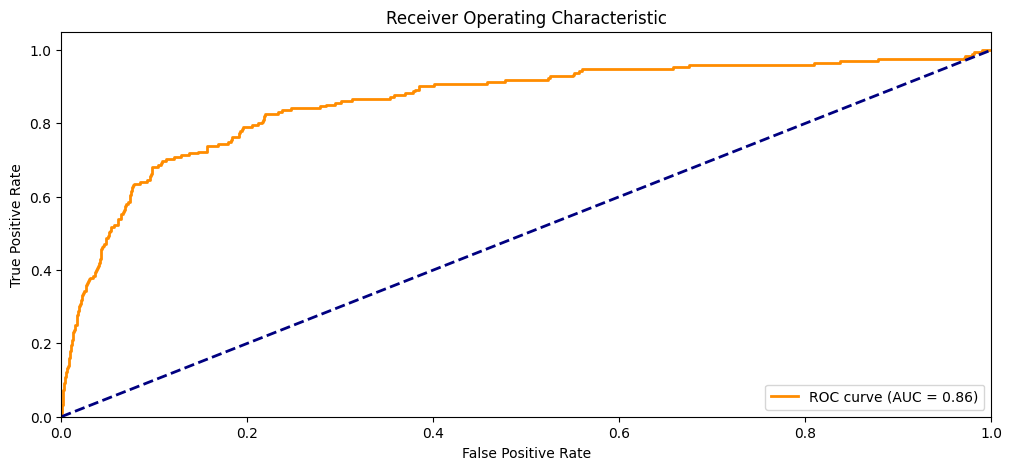

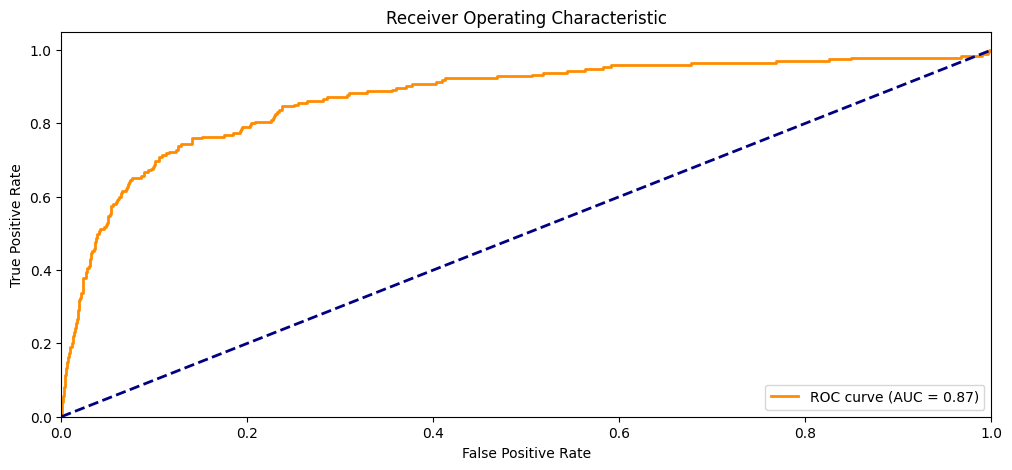

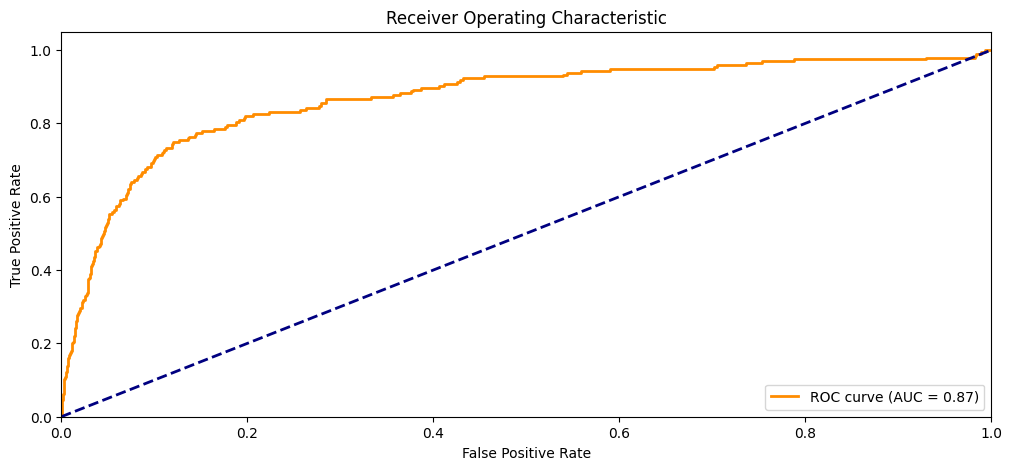

In [12]:

from sklearn.metrics import roc_curve, auc, roc_auc_score

# Initialize model, optimizer, and loss
#defining alpha and gamma
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=250,shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=250,shuffle=False)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)
alpha = torch.tensor([28675/(1730+28675),1730/(1730+28675)], dtype=torch.float32)  # Minority:Majority weights

criterion = FocalLoss(alpha=alpha, gamma=2)

# Training loop
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop to compute ROC AUC
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of minority class (class=1)
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Compute ROC AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"Epoch {epoch+1}, ROC AUC: {roc_auc:.4f}")
     # Plotting
    plt.figure(figsize=(12, 5))


    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

Epoch 1, ROC AUC: 0.8698
Epoch 2, ROC AUC: 0.8713
Epoch 3, ROC AUC: 0.8780
Epoch 4, ROC AUC: 0.8687
Epoch 5, ROC AUC: 0.8759
Epoch 6, ROC AUC: 0.8709
Epoch 7, ROC AUC: 0.8771
Epoch 8, ROC AUC: 0.8654
Epoch 9, ROC AUC: 0.8801
Epoch 10, ROC AUC: 0.8615
Epoch 11, ROC AUC: 0.8740
Epoch 12, ROC AUC: 0.8709
Epoch 13, ROC AUC: 0.8581
Epoch 14, ROC AUC: 0.8835
Epoch 15, ROC AUC: 0.8744
Epoch 16, ROC AUC: 0.8825
Epoch 17, ROC AUC: 0.8615
Epoch 18, ROC AUC: 0.8638
Epoch 19, ROC AUC: 0.8545
Epoch 20, ROC AUC: 0.8674


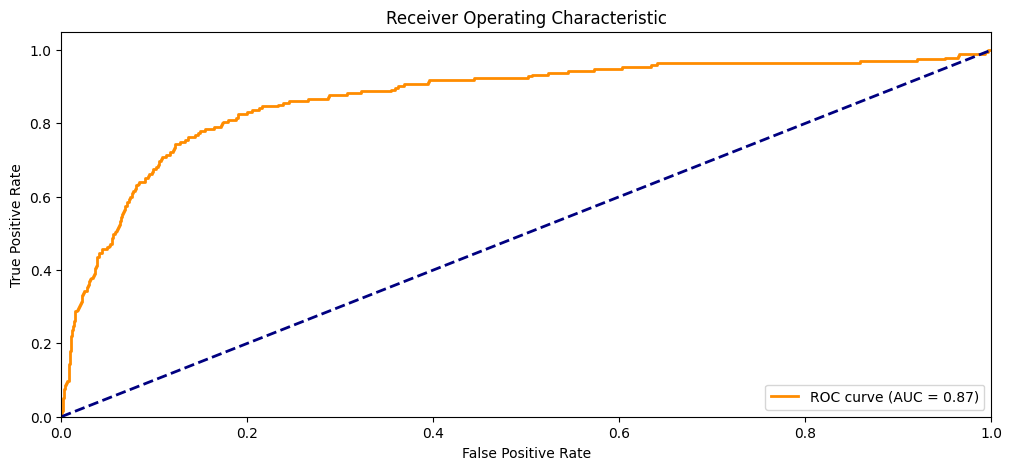

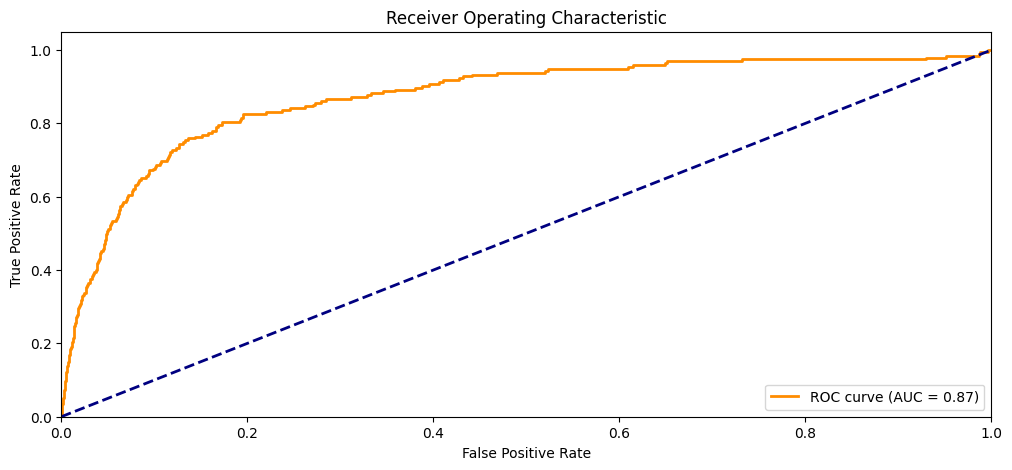

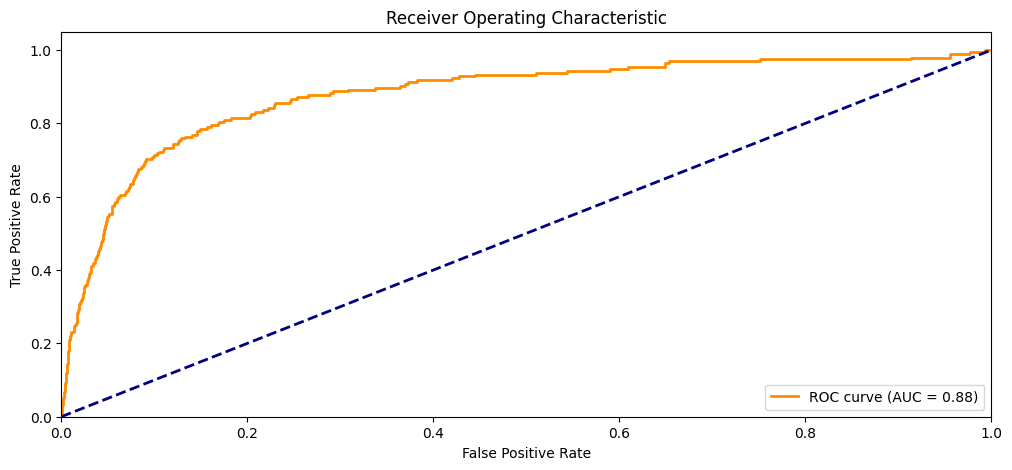

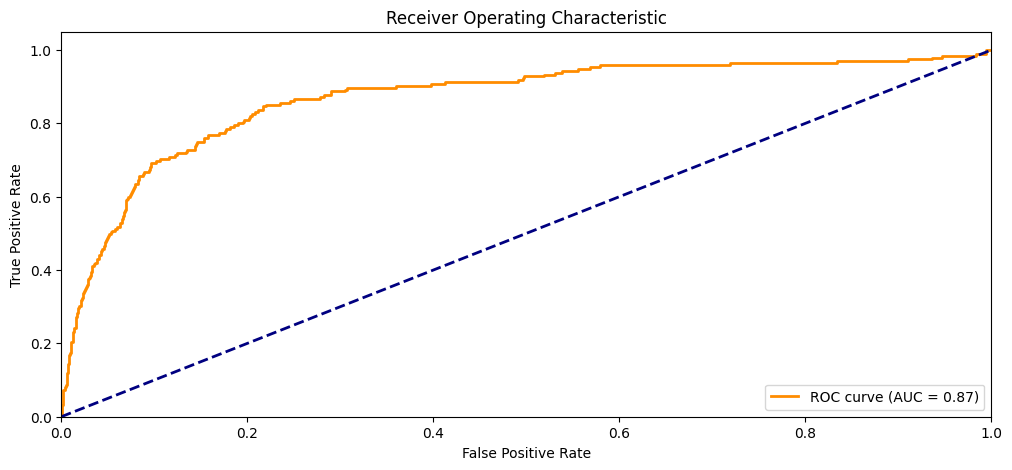

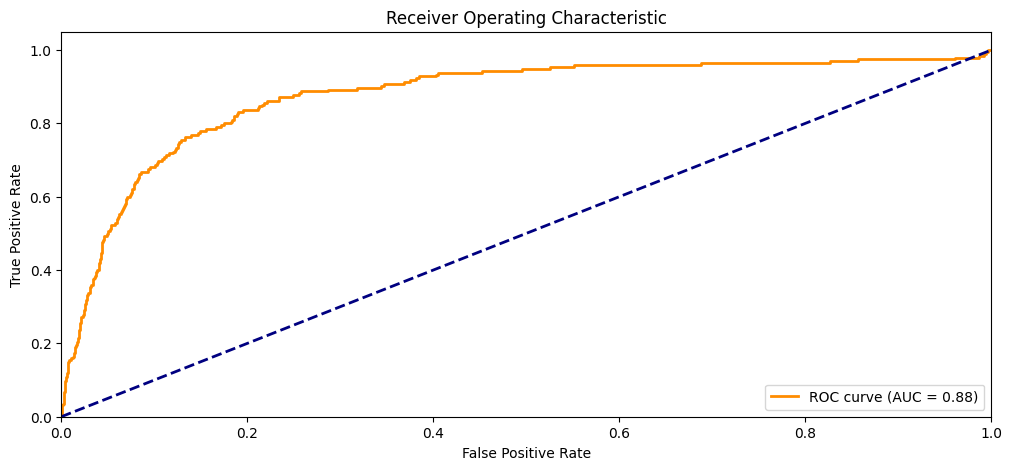

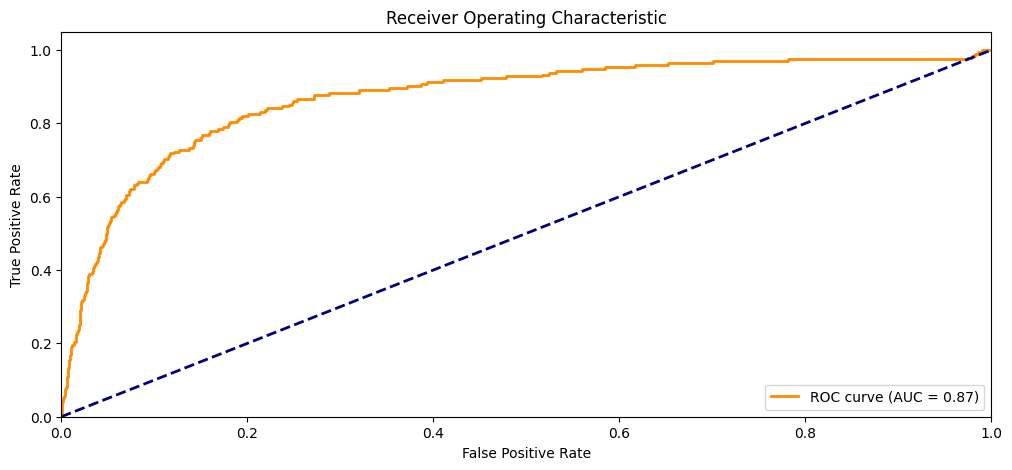

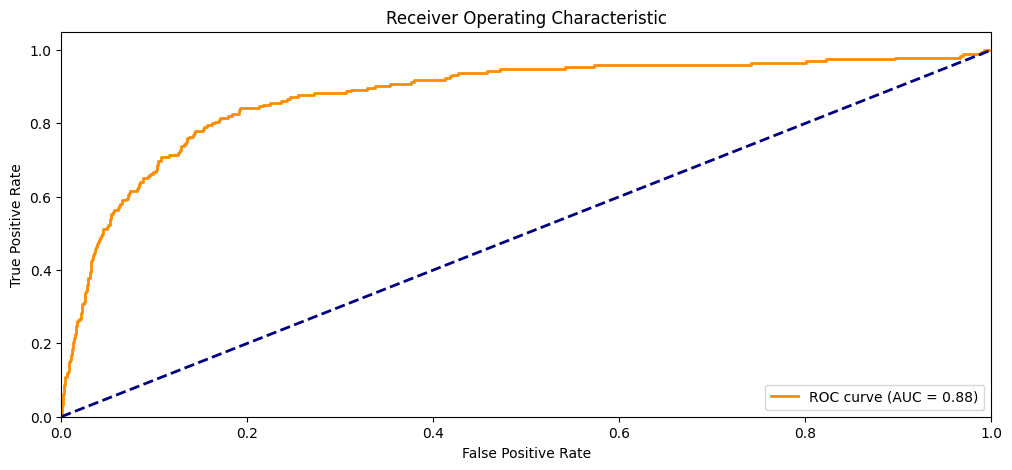

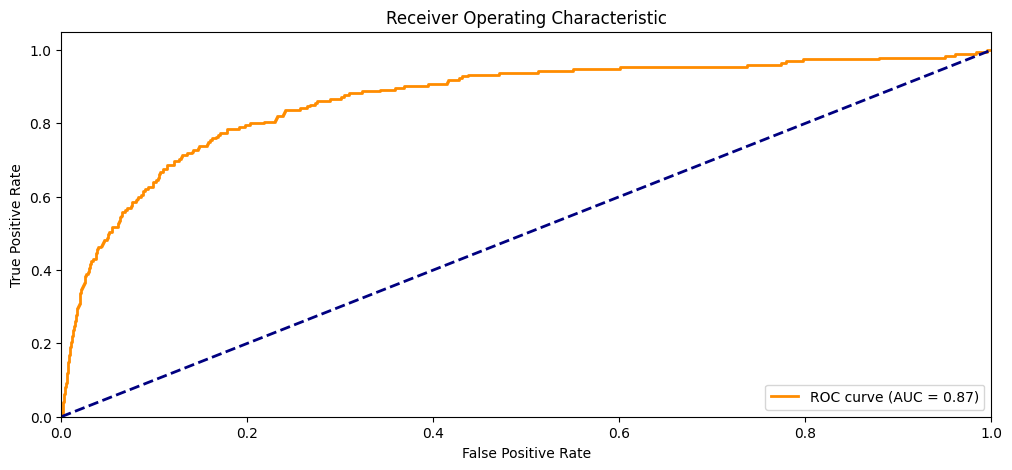

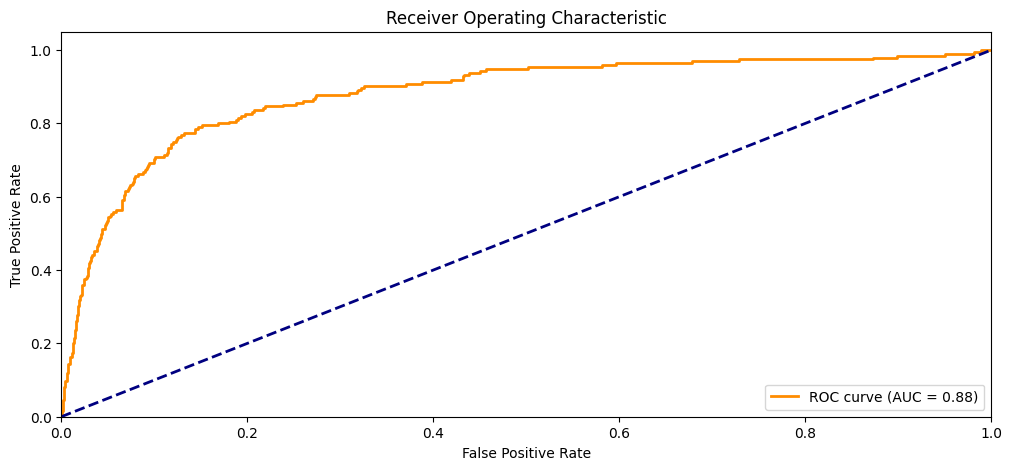

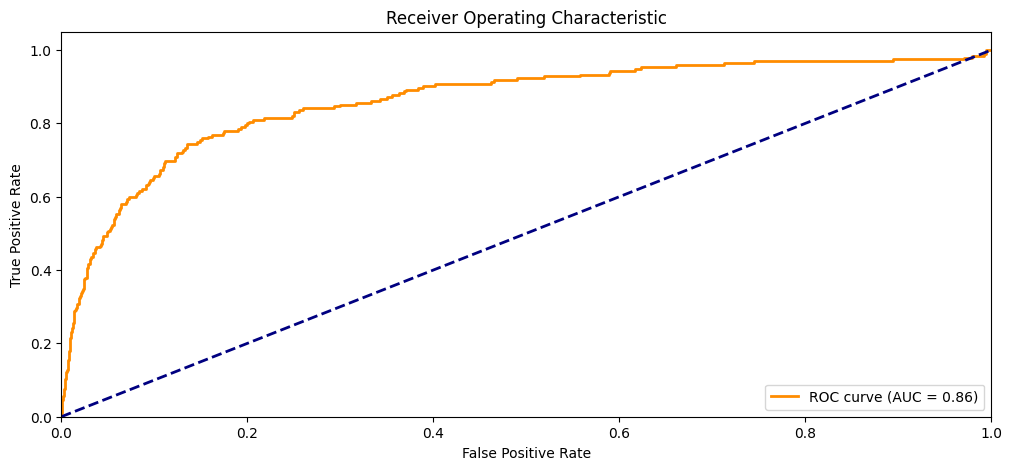

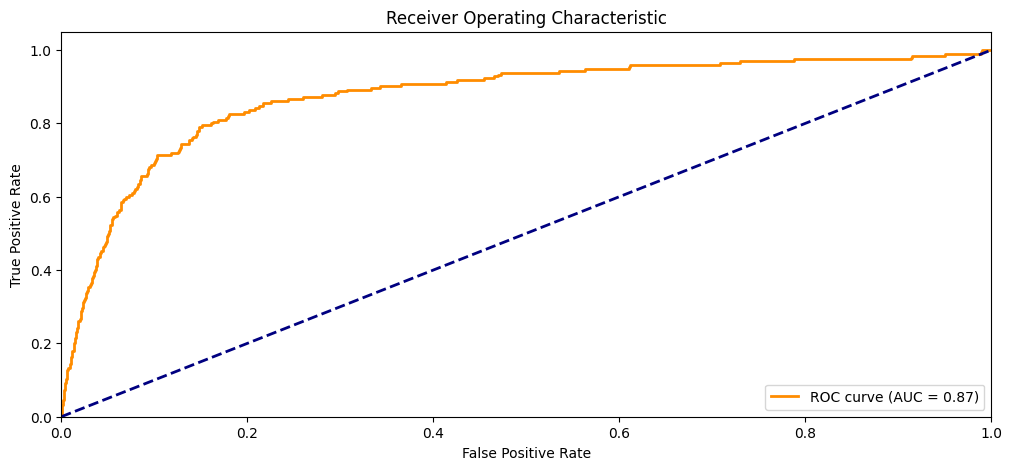

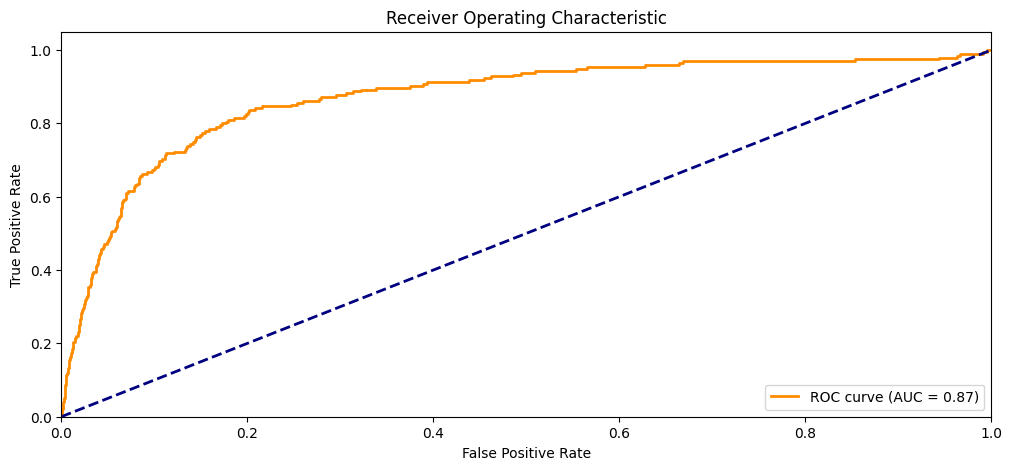

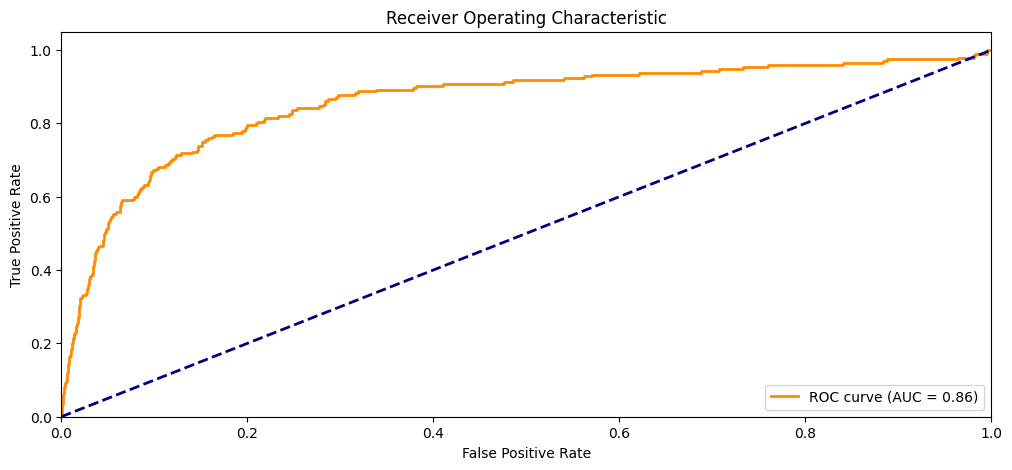

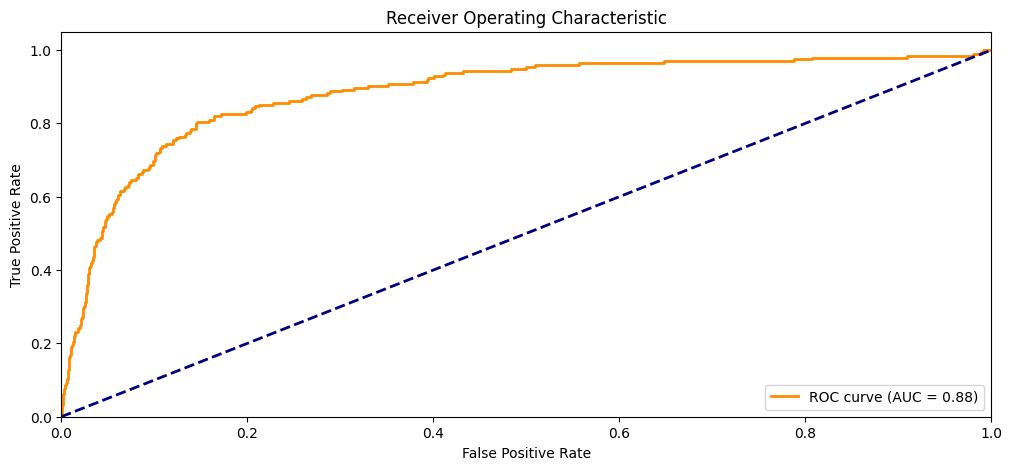

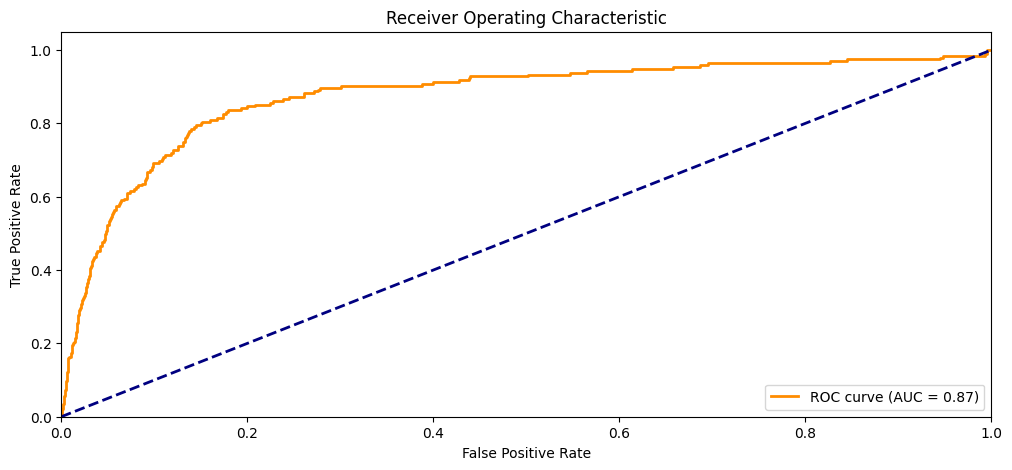

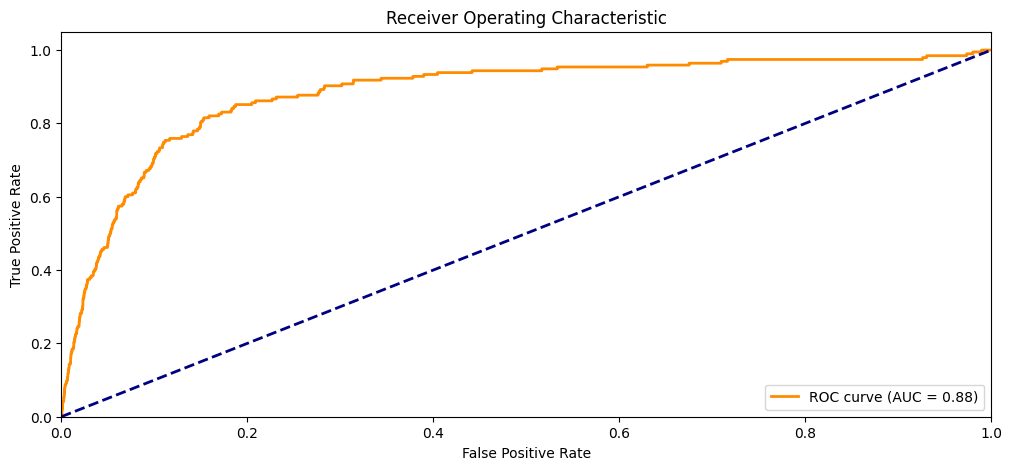

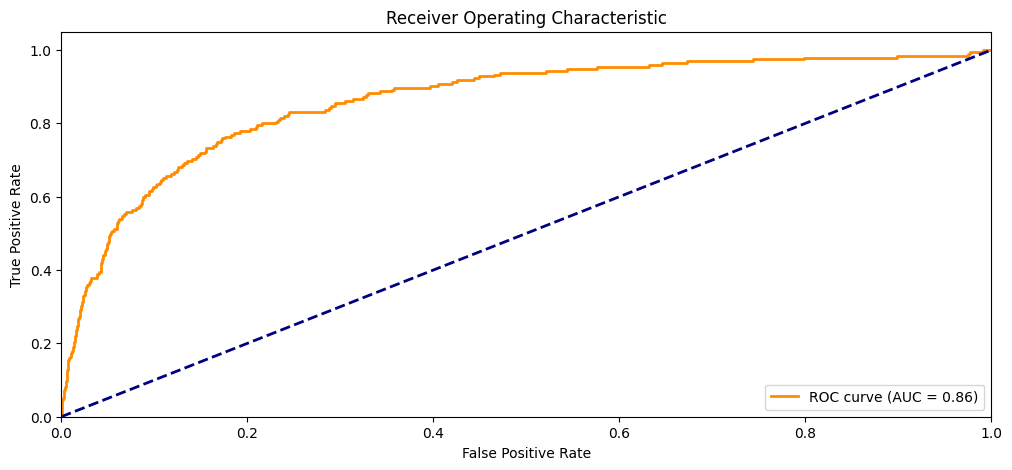

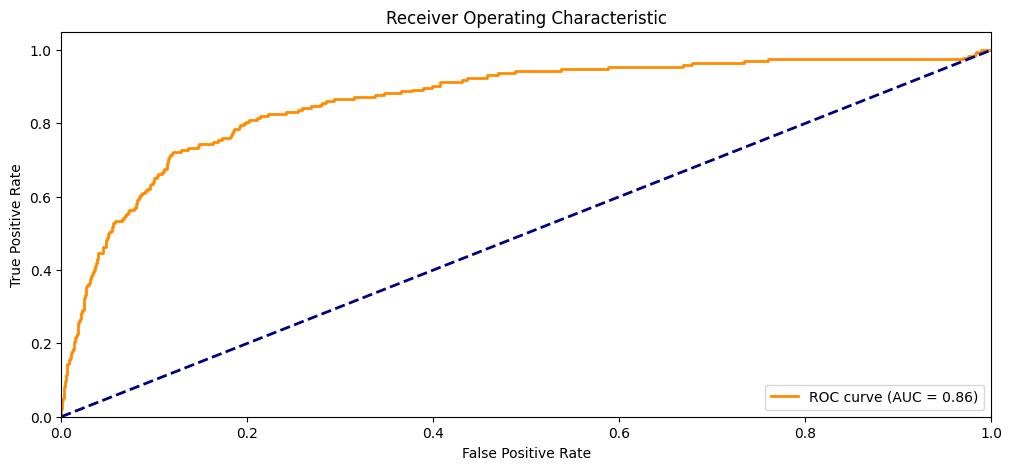

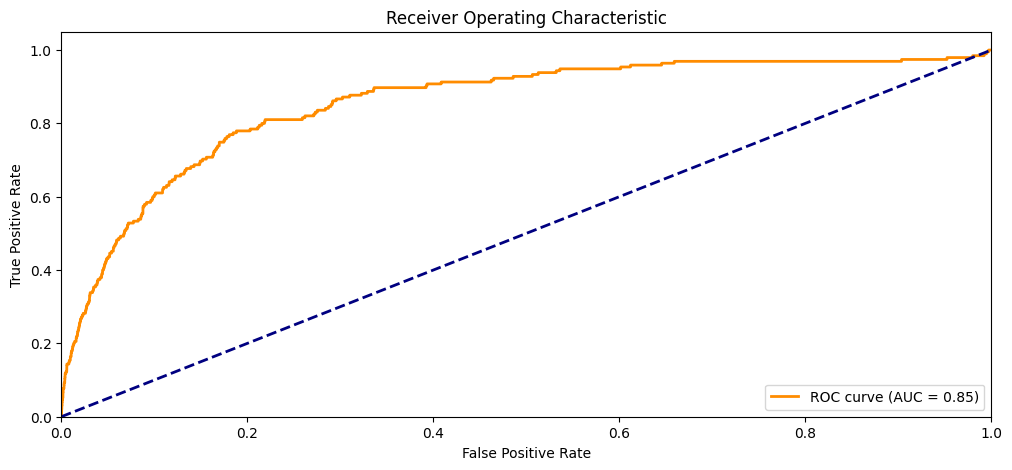

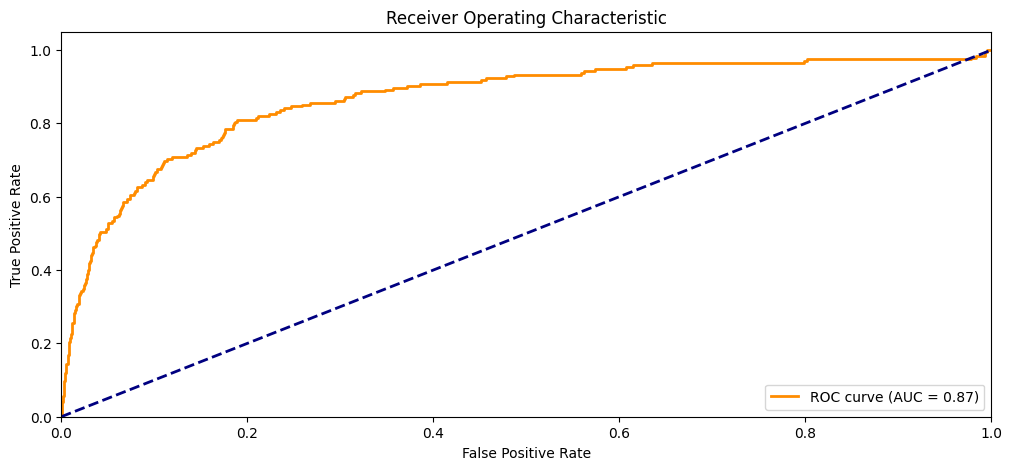

In [18]:
# Initialize model, optimizer, and loss
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=250,shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=250,shuffle=False)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)
alpha = torch.tensor([28675/(1730+28675),1730/(1730+28675)], dtype=torch.float32)  # Minority:Majority weights

criterion = FocalLoss(alpha=alpha, gamma=3.75)

# Training loop
for epoch in range(20):
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop to compute ROC AUC
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of minority class (class=1)
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Compute ROC AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"Epoch {epoch+1}, ROC AUC: {roc_auc:.4f}")
     # Plotting
    plt.figure(figsize=(12, 5))


    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

Above ROC AUC curves have been plotted using different set of hyperparamet combinations, but highest ROC AUC scores are acheived using gamma=3.5-4